<a href="https://colab.research.google.com/github/D34thM4ch1n3/Stock-Price-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Prediction**
made by Mohammad Shammer for Codec Technologies Internship project

In [1]:
!pip install yfinance xgboost --quiet


In [2]:
# Reference: GeeksForGeeks - Stock Price Prediction using ML in Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [3]:
import yfinance as yf

# Download Tesla stock data (Jan 2010 - Dec 2017) matching GeeksForGeeks dataset
df = yf.download('TSLA', start='2010-01-01', end='2017-12-31')
df.reset_index(inplace=True)

# Flatten MultiIndex columns if present
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Drop Adj Close (same as Close per GFG article)
if 'Adj Close' in df.columns:
    df.drop('Adj Close', axis=1, inplace=True)

print("Shape:", df.shape)
print(df.head())


[*********************100%***********************]  1 of 1 completed

Shape: (1891, 6)
        Date     Close      High       Low      Open     Volume
0 2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
1 2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2 2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
3 2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
4 2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [4]:
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1891 non-null   datetime64[ns]
 1   Close   1891 non-null   float64       
 2   High    1891 non-null   float64       
 3   Low     1891 non-null   float64       
 4   Open    1891 non-null   float64       
 5   Volume  1891 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 88.8 KB
None

Descriptive Statistics:


,Date,Close,High,Low,Open,Volume
count,1891,1891.000000,1891.000000,1891.000000,1891.000000,1.891000e+03
mean,2014-03-30 11:12:24.368059136,10.220165,10.391504,10.040740,10.222362,6.773980e+07
min,2010-06-29 00:00:00,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,2012-05-12 12:00:00,2.088000,2.127667,2.041333,2.085000,1.967175e+07
50%,2014-04-01 00:00:00,12.576000,12.800000,12.281333,12.572667,5.412750e+07
75%,2016-02-16 12:00:00,15.579000,15.864334,15.327000,15.648000,9.050250e+07
max,2017-12-29 00:00:00,25.666668,25.974001,25.290001,25.779333,5.574585e+08
std,NaN,7.224437,7.322058,7.120176,7.227633,6.351916e+07


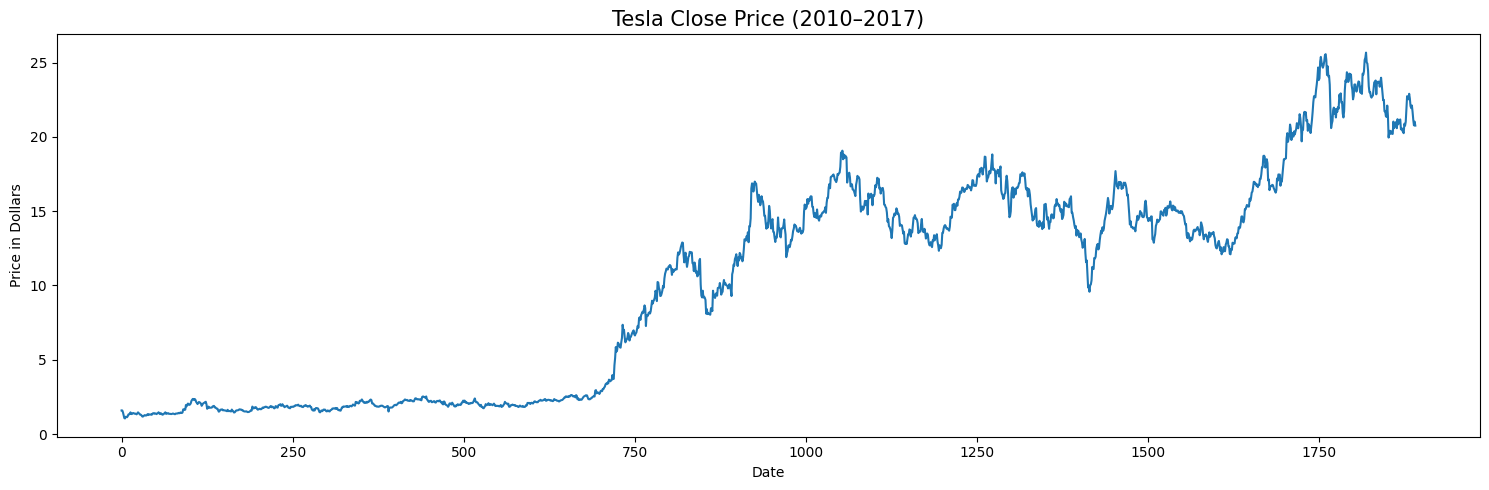

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Tesla Close Price (2010–2017)', fontsize=15)
plt.ylabel('Price in Dollars')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [6]:
print("Null values in each column:")
print(df.isnull().sum())


Null values in each column:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


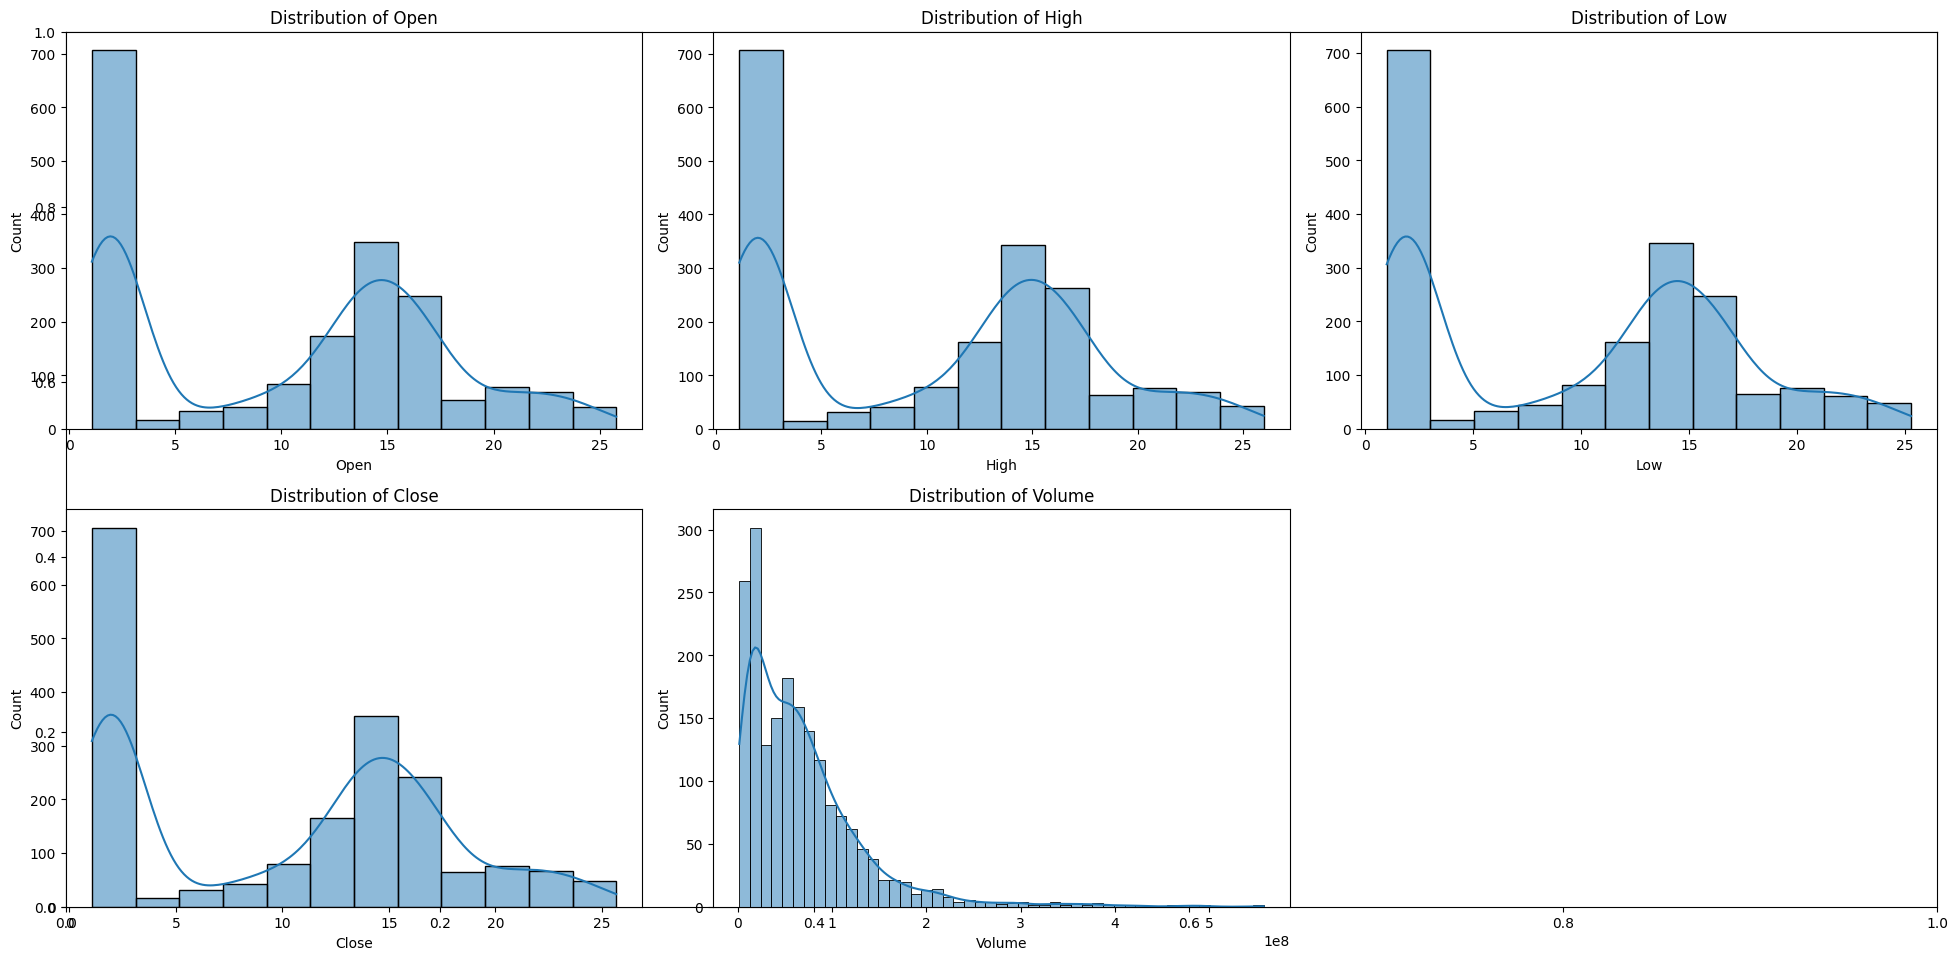

In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sb.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


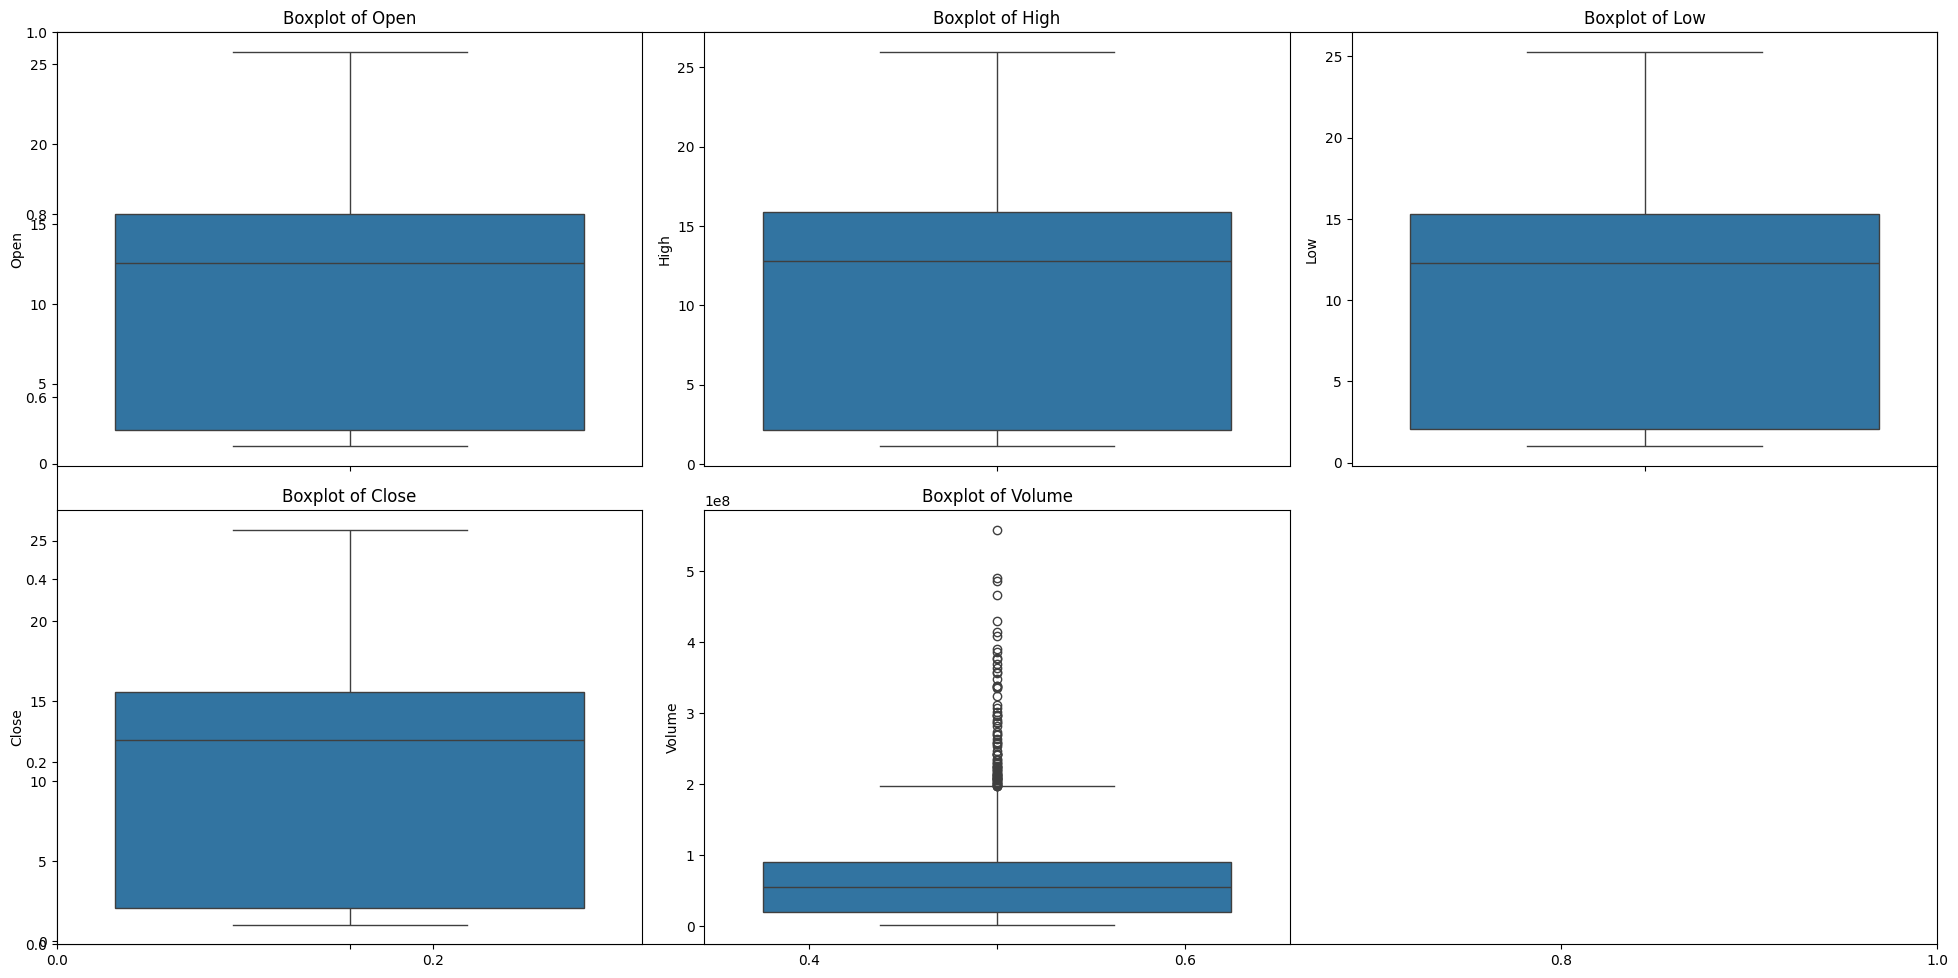

In [8]:
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sb.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [9]:
# Extract date components
df['day']   = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year']  = df['Date'].dt.year

# Mark quarter-end months (March=3, June=6, September=9, December=12)
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)

# Derived price features
df['open-close'] = df['Open'] - df['Close']
df['low-high']   = df['Low']  - df['High']

# Target: 1 = next day's close is higher (buy signal), 0 = don't buy
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

print(df[['Date', 'Open', 'Close', 'open-close', 'low-high', 'is_quarter_end', 'target']].head(10))


        Date      Open     Close  open-close  low-high  is_quarter_end  target
0 2010-06-29  1.266667  1.592667   -0.326000 -0.497334               1       0
1 2010-06-30  1.719333  1.588667    0.130666 -0.474667               1       0
2 2010-07-01  1.666667  1.464000    0.202667 -0.376667               0       0
3 2010-07-02  1.533333  1.280000    0.253333 -0.292667               0       0
4 2010-07-06  1.333333  1.074000    0.259333 -0.278000               0       0
5 2010-07-07  1.093333  1.053333    0.040000 -0.110000               0       1
6 2010-07-08  1.076000  1.164000   -0.088000 -0.130000               0       0
7 2010-07-09  1.172000  1.160000    0.012000 -0.090000               0       0
8 2010-07-12  1.196667  1.136667    0.060000 -0.071334               0       1
9 2010-07-13  1.159333  1.209333   -0.050000 -0.116000               0       1


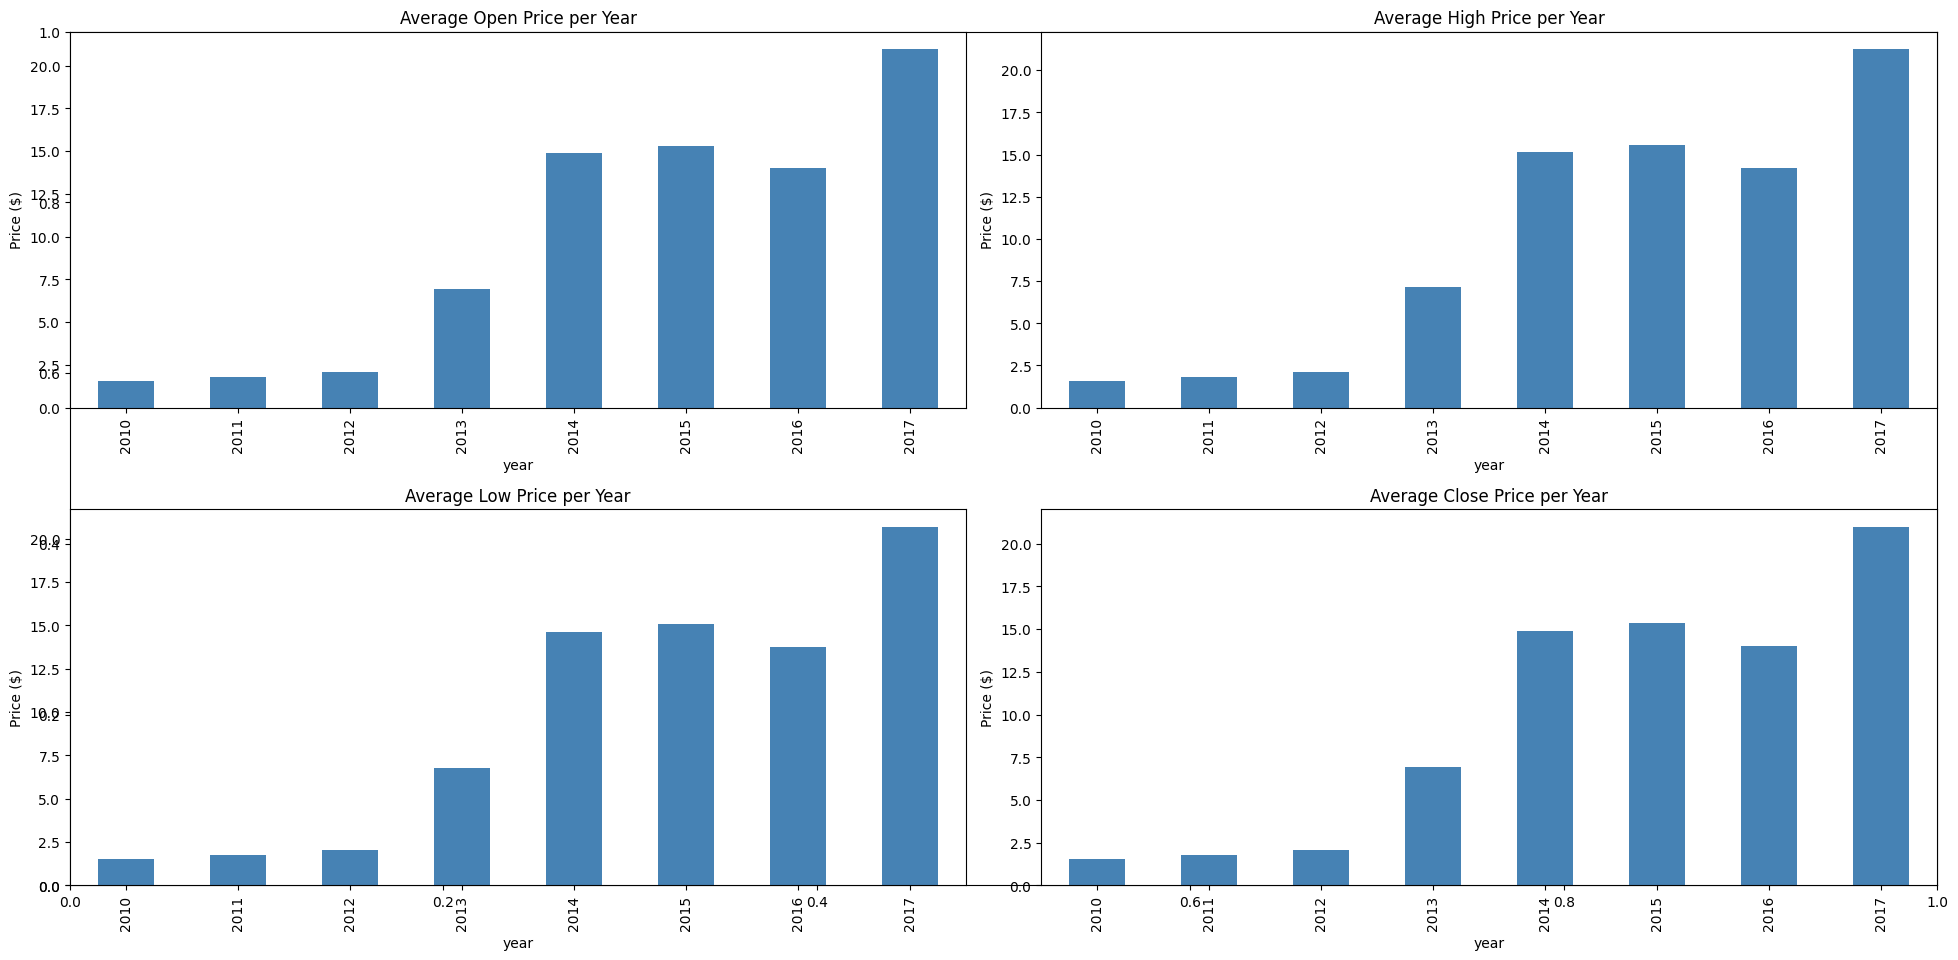

In [10]:
data_grouped = df.drop('Date', axis=1).groupby('year').mean(numeric_only=True)
plt.subplots(figsize=(20, 10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    data_grouped[col].plot.bar(color='steelblue')
    plt.title(f'Average {col} Price per Year')
    plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()


In [11]:
print("Average metrics grouped by Quarter End:")
print(df.drop('Date', axis=1).groupby('is_quarter_end').mean(numeric_only=True))


Average metrics grouped by Quarter End:
                    Close       High        Low       Open        Volume  \
is_quarter_end                                                             
0               10.043919  10.216458   9.857860  10.045052  7.039629e+07   
1               10.566304  10.735284  10.399908  10.570590  6.252260e+07   

                      day     month         year  open-close  low-high  \
is_quarter_end                                                           
0               15.696728  6.285714  2013.723065    0.001134 -0.358598   
1               15.835423  7.641066  2013.730408    0.004286 -0.335376   

                  target  
is_quarter_end            
0               0.506784  
1               0.525078  


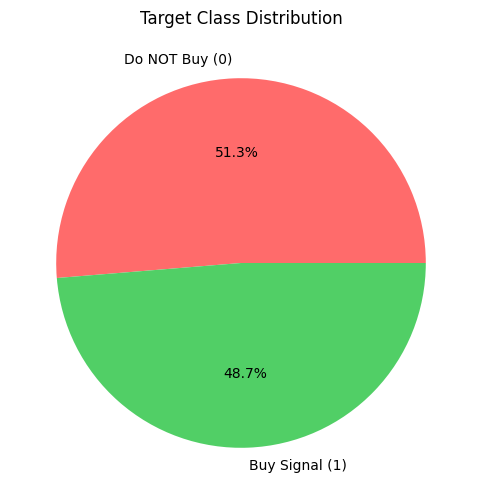

In [12]:
plt.figure(figsize=(6, 6))
plt.pie(
    df['target'].value_counts().values,
    labels=['Do NOT Buy (0)', 'Buy Signal (1)'],
    autopct='%1.1f%%',
    colors=['#ff6b6b', '#51cf66']
)
plt.title('Target Class Distribution')
plt.show()


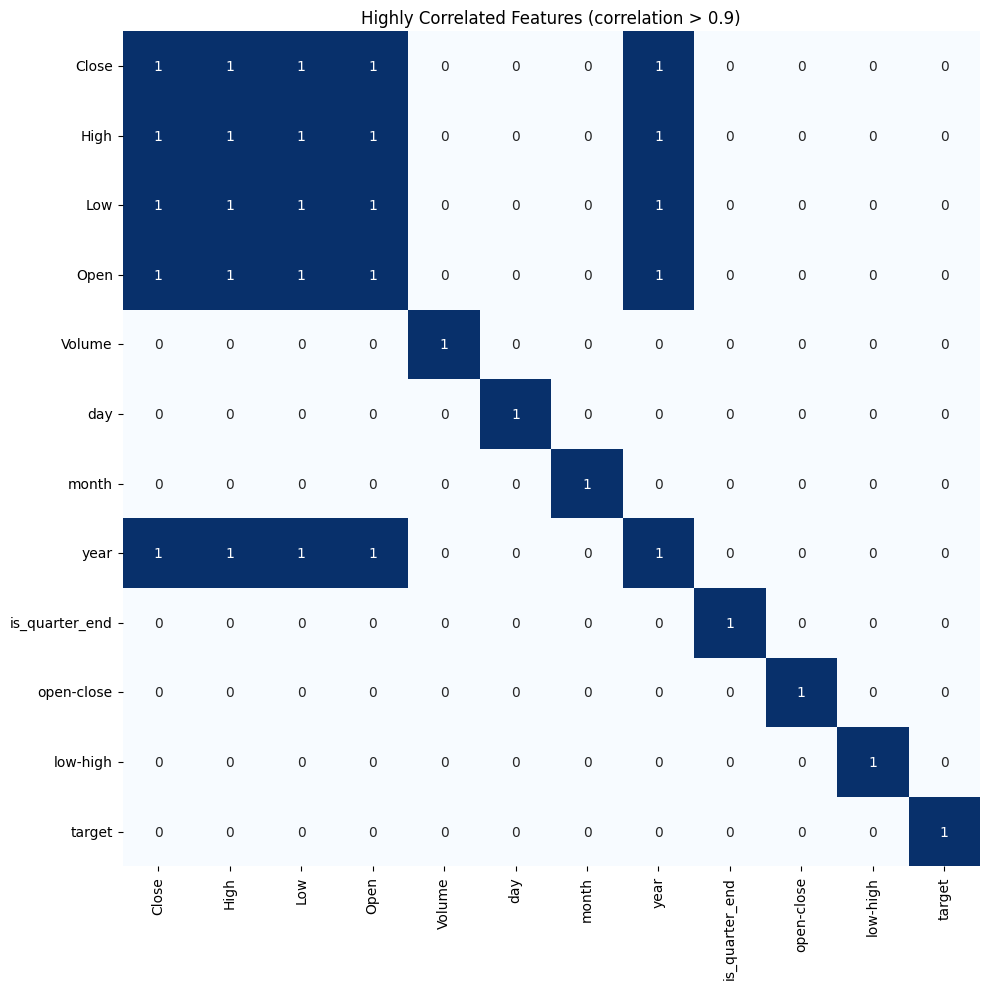

In [13]:
plt.figure(figsize=(10, 10))
sb.heatmap(
    df.drop('Date', axis=1).corr(numeric_only=True) > 0.9,
    annot=True,
    cbar=False,
    cmap='Blues'
)
plt.title('Highly Correlated Features (correlation > 0.9)')
plt.tight_layout()
plt.show()


In [14]:
features_cols = ['open-close', 'low-high', 'is_quarter_end']
target_col    = 'target'

X = df[features_cols]
y = df[target_col]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 90% train, 10% validation split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_scaled, y, test_size=0.1, random_state=2022
)

print(f"Training set size   : {X_train.shape}")
print(f"Validation set size : {X_valid.shape}")


Training set size   : (1701, 3)
Validation set size : (190, 3)


In [15]:
# GFG uses: Logistic Regression, SVM, XGBoost
models = [
    LogisticRegression(),
    SVC(kernel='poly', probability=True),
    XGBClassifier(eval_metric='logloss')
]

model_names = ['Logistic Regression', 'SVM (Poly Kernel)', 'XGBoost Classifier']

results = []
for i, model in enumerate(models):
    model.fit(X_train, Y_train)

    train_acc = metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
    valid_acc = metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1])

    results.append({
        'Model': model_names[i],
        'Train ROC-AUC': round(train_acc, 4),
        'Validation ROC-AUC': round(valid_acc, 4)
    })

    print(f"\n📊 {model_names[i]}")
    print(f"   Training   ROC-AUC : {train_acc:.4f}")
    print(f"   Validation ROC-AUC : {valid_acc:.4f}")

print("\n\n✅ All models trained!")



📊 Logistic Regression
   Training   ROC-AUC : 0.5292
   Validation ROC-AUC : 0.4764

📊 SVM (Poly Kernel)
   Training   ROC-AUC : 0.4781
   Validation ROC-AUC : 0.5309

📊 XGBoost Classifier
   Training   ROC-AUC : 0.9455
   Validation ROC-AUC : 0.4071


✅ All models trained!


In [16]:
results_df = pd.DataFrame(results)
print("\n📋 Model Performance Summary:")
print(results_df.to_string(index=False))



📋 Model Performance Summary:
              Model  Train ROC-AUC  Validation ROC-AUC
Logistic Regression         0.5292              0.4764
  SVM (Poly Kernel)         0.4781              0.5309
 XGBoost Classifier         0.9455              0.4071


Confusion Matrix – Logistic Regression (Validation Set):


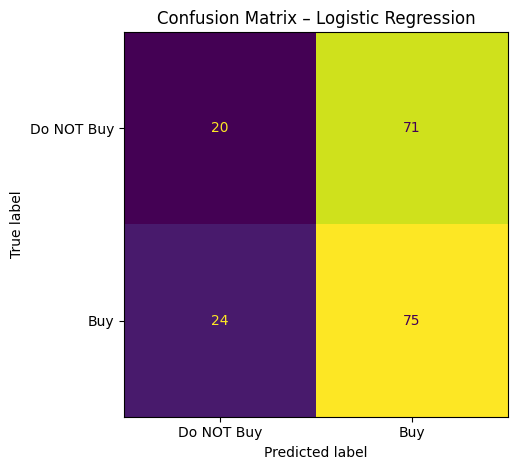

In [17]:
print("Confusion Matrix – Logistic Regression (Validation Set):")
ConfusionMatrixDisplay.from_estimator(
    models[0], X_valid, Y_valid,
    display_labels=['Do NOT Buy', 'Buy'],
    colorbar=False
)
plt.title('Confusion Matrix – Logistic Regression')
plt.tight_layout()
plt.show()


In [18]:
# Predict buy signal for a custom stock day
# Format: [open-close, low-high, is_quarter_end]
sample = np.array([[1.5, -3.2, 1]])   # quarter-end day, open > close (bearish)
sample_scaled = scaler.transform(sample)

prediction = models[0].predict(sample_scaled)
probability = models[0].predict_proba(sample_scaled)[0]

print(f"Prediction  : {'✅ BUY Signal' if prediction[0] == 1 else '🚫 Do NOT Buy'}")
print(f"Probability : Buy={probability[1]:.2f} | No Buy={probability[0]:.2f}")


Prediction  : ✅ BUY Signal
Probability : Buy=0.62 | No Buy=0.38
